<a href="https://colab.research.google.com/github/palomaalves/Notebooks_Machine_Learning/blob/main/Desafio_04_Assessment_PalomaAlves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a href="https://www.nvidia.com/dli"> <img src="https://drive.google.com/uc?id=1J3bpGyJcz-7uOFkUNhvOBiReBCk-sUwR" width="200" </a></center>

# Assessment

In this assessment, you will train a new model that is able to recognize fresh and rotten fruit. You will need to get the model to a validation accuracy of `92%` in order to pass the assessment, though we challenge you to do even better if you can. You will have the use the skills that you learned in the previous exercises. Specifically, we suggest using some combination of transfer learning, data augmentation, and fine tuning. Once you have trained the model to be at least 92% accurate on the validation dataset, save your model, and then assess its accuracy. Let's get started!

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Fundamentals_Deep_Learning

!ls

/content/gdrive/MyDrive/Fundamentals_Deep_Learning
001_tensorflow.ipynb  03_asl_cnn.ipynb		  05b_presidential_doggy_door.ipynb  images
00_jupyterlab.ipynb   04a_asl_augmentation.ipynb  06_headline_generator.ipynb
01_mnist.ipynb	      04b_asl_predictions.ipynb   asl_model
02_asl.ipynb	      05a_doggy_door.ipynb	  data


## The Dataset

In this exercise, you will train a model to recognize fresh and rotten fruits. The dataset comes from [Kaggle](https://www.kaggle.com/sriramr/fruits-fresh-and-rotten-for-classification), a great place to go if you're interested in starting a project after this class. The dataset structure is in the `data/fruits` folder. There are 6 categories of fruits: fresh apples, fresh oranges, fresh bananas, rotten apples, rotten oranges, and rotten bananas. This will mean that your model will require an output layer of 6 neurons to do the categorization successfully. You'll also need to compile the model with `categorical_crossentropy`, as we have more than two categories.

<img src="https://drive.google.com/uc?id=1ryuTigL-jyigpICE-veqLZvPz1DCg4ml" style="width: 600px;">

## Load ImageNet Base Model

We encourage you to start with a model pretrained on ImageNet. Load the model with the correct weights, set an input shape, and choose to remove the last layers of the model. Remember that images have three dimensions: a height, and width, and a number of channels. Because these pictures are in color, there will be three channels for red, green, and blue. We've filled in the input shape for you. This cannot be changed or the assessment will fail. If you need a reference for setting up the pretrained model, please take a look at [notebook 05b] where we implemented transfer learning.

In [ ]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


## Freeze Base Model

Next, we suggest freezing the base model, as done in [notebook 05b]. This is done so that all the learning from the ImageNet dataset does not get destroyed in the initial training.

In [ ]:
# Freeze base model
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Add Layers to Model

Now it's time to add layers to the pretrained model. [Notebook 05b] can be used as a guide. Pay close attention to the last dense layer and make sure it has the correct number of neurons to classify the different types of fruit.

In [ ]:
# Create inputs with correct shape
inputs = keras.Input(shape=(224,224,3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(6, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 14717766 (56.14 MB)
Trainable params: 3078 (12.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


## Compile Model

Now it's time to compile the model with loss and metrics options. Remember that we're training on a number of different categories, rather than a binary classification problem.

In [ ]:
model.compile(loss = keras.losses.CategoricalCrossentropy(from_logits=True), metrics = [keras.metrics.CategoricalAccuracy()])

## Augment the Data

If you'd like, try to augment the data to improve the dataset. Feel free to look at [notebook 04a] and [notebook 05b] for augmentation examples. There is also documentation for the [Keras ImageDataGenerator class](https://keras.io/api/preprocessing/image/#imagedatagenerator-class). This step is optional, but it may be helpful to get to 92% accuracy.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    samplewise_center=True,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
datagen_valid = ImageDataGenerator(samplewise_center=True)

## Load Dataset

Now it's time to load the train and validation datasets. Pick the right folders, as well as the right `target_size` of the images (it needs to match the height and width input of the model you've created). For a reference, check out [notebook 05b].

In [ ]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    'data/fruits/train',
    target_size=(224,224),
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    'data/fruits/valid',
    target_size=(224,224),
    color_mode="rgb",
    class_mode="categorical",
)

Found 1182 images belonging to 6 classes.
Found 329 images belonging to 6 classes.


## Train the Model

Time to train the model! Pass the `train` and `valid` iterators into the `fit` function, as well as setting the desired number of epochs.

In [ ]:
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 772s 21s/step - loss: 1.9869 - categorical_accuracy: 0.5169 - val_loss: 1.1370 - val_categorical_accuracy: 0.6900
Epoch 2/10
36/36 [==============================] - 33s 893ms/step - loss: 0.6256 - categorical_accuracy: 0.7995 - val_loss: 0.5891 - val_categorical_accuracy: 0.8237
Epoch 3/10
36/36 [==============================] - 35s 955ms/step - loss: 0.3293 - categorical_accuracy: 0.8816 - val_loss: 0.3884 - val_categorical_accuracy: 0.8784
Epoch 4/10
36/36 [==============================] - 30s 813ms/step - loss: 0.2014 - categorical_accuracy: 0.9289 - val_loss: 0.3447 - val_categorical_accuracy: 0.8845
Epoch 5/10
36/36 [==============================] - 29s 784ms/step - loss: 0.1526 - categorical_accuracy: 0.9459 - val_loss: 0.2108 - val_categorical_accuracy: 0.9271
Epoch 6/10
36/36 [==============================] - 29s 777ms/step - loss: 0.1237 - categorical_accuracy: 0.9602 - val_loss: 0.1838 - val_categorical_accuracy: 0.9483
Epoch 7/10

## Unfreeze Model for Fine Tuning

If you have reached 92% validation accuracy already, this next step is optional. If not, we suggest fine tuning the model with a very low learning rate.

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),
              loss = keras.losses.CategoricalCrossentropy(from_logits=True) , metrics = [keras.metrics.CategoricalAccuracy()])

In [ ]:
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples/train_it.batch_size,
          validation_steps=valid_it.samples/valid_it.batch_size,
          epochs=15)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 58s 1s/step - loss: 0.0986 - categorical_accuracy: 0.9687 - val_loss: 0.0924 - val_categorical_accuracy: 0.9696
Epoch 2/15
36/36 [==============================] - 31s 848ms/step - loss: 0.0362 - categorical_accuracy: 0.9898 - val_loss: 0.1752 - val_categorical_accuracy: 0.9544
Epoch 3/15
36/36 [==============================] - 32s 852ms/step - loss: 0.0234 - categorical_accuracy: 0.9907 - val_loss: 0.3302 - val_categorical_accuracy: 0.9271
Epoch 4/15
36/36 [==============================] - 34s 904ms/step - loss: 0.0116 - categorical_accuracy: 0.9975 - val_loss: 0.1043 - val_categorical_accuracy: 0.9818
Epoch 5/15
36/36 [==============================] - 34s 912ms/step - loss: 0.0238 - categorical_accuracy: 0.9958 - val_loss: 0.2105 - val_categorical_accuracy: 0.9605
Epoch 6/15
36/36 [==============================] - 31s 848ms/step - loss: 0.0060 - categorical_accuracy: 0.9983 - val_loss: 0.1799 - val_categorical_accuracy: 0.9666
Epoch 7/15
3

## Evaluate the Model

Hopefully, you now have a model that has a validation accuracy of 92% or higher. If not, you may want to go back and either run more epochs of training, or adjust your data augmentation.

Once you are satisfied with the validation accuracy, evaluate the model by executing the following cell. The evaluate function will return a tuple, where the first value is your loss, and the second value is your accuracy. To pass, the model will need have an accuracy value of `92% or higher`.

In [ ]:
model.evaluate(valid_it, steps=valid_it.samples/valid_it.batch_size)

10/10 [==============================] - 3s 283ms/step - loss: 0.1045 - categorical_accuracy: 0.9818


[0.10454504936933517, 0.9817629456520081]

# Examining the Predictions

Now that we have a well-trained model, let's test the model prediction with images from the internet, representing the 06 fruit classes.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

labels = ['fresh apple','fresh banana','fresh orange','rotten apple','rotten banana','rotten orange']

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

1/1 [==============================] - 1s 1s/step


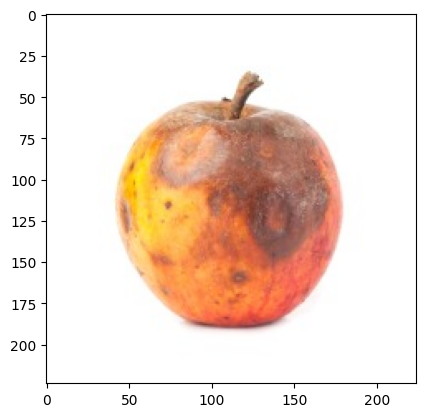

In [ ]:
result = make_predictions('data/fruits/test/apple_rotten.jpeg')
class_result = result.argmax()
score_result = result[0][class_result]

In [ ]:
print(f"Result: {labels[class_result]} (Score: {score_result:.2f})")

Result: rotten apple (Score: 1.00)


In [ ]:
print(f"Score: {score_result:.2f}")

Score: 1.00
